In [46]:
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
from networkx.algorithms import community, centrality
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline 
from datetime import datetime, timedelta
from datetime import date
import powerlaw
from collections import defaultdict, Counter
from networkx.algorithms import community
from networkx.algorithms import bipartite
from networkx.algorithms import centrality as ce
from networkx.algorithms import community as c
from IPython.display import display, HTML
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities

In [3]:
file= 'data/Investments.xlsx'
df = pd.read_excel(file)

### Preprocess

In [4]:
df = df[['company_name','company_market','investor_name','funded_year','raised_amount_usd']]
df.rename(columns = {'company_name' : 'Company_Name', 'company_market' : 'Company_Market', 'investor_name':'Investor_Name', 'funded_year':'Funded_Year', 'raised_amount_usd':'Raised_Amount_USD'}, inplace = True)
df = df.dropna()
df = df[df.Raised_Amount_USD != 0]
df = df[df.Funded_Year>=1990]

In [5]:
df.head()

,Company_Name,Company_Market,Investor_Name,Funded_Year,Raised_Amount_USD
31,Knowledge Adventure,Games,William Lohse,1990,60000.0
43,Market Wire,Advertising,Hummer Winblad Venture Partners,1990,17550000.0
44,Market Wire,Advertising,Mindful Investors,1990,17550000.0
45,Market Wire,Advertising,Montreux Equity Partners,1990,17550000.0
46,Market Wire,Advertising,Osprey Ventures,1990,17550000.0


### Data exploration

In [6]:
print(f"Number of unique investors: {df['Investor_Name'].nunique()}")
print(f"Number of unique companies: {df['Company_Name'].nunique()}")
print(f"Number of unique company markets: {df['Company_Market'].nunique()}")
print(f"Number of unique years: {df['Funded_Year'].nunique()}")
print(f"Number of investments: {df.shape[0]}")

Number of unique investors: 20156
Number of unique companies: 24908
Number of unique company markets: 695
Number of unique years: 23
Number of investments: 99090


#### Building the network

In [7]:
G_weighted_directed = nx.from_pandas_edgelist(df=df,source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
print('General information about the graph (all data):\n\n',nx.info(G_weighted_directed))

General information about the graph (all data):

 Name: 
Type: MultiDiGraph
Number of nodes: 44777
Number of edges: 99090
Average in degree:   2.2130
Average out degree:   2.2130


#### Split the data by years

In [8]:
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]
years_dict = {i:year_range for i,year_range in enumerate(years_range)}
df_list =[df[(df['Funded_Year'] <= year_range[1]) & (df['Funded_Year'] >= year_range[0])] for year_range in years_range]
graph_list = [nx.from_pandas_edgelist(df_list[i],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph()) for i, _ in enumerate(years_range)]

#### General distributions

   Years     :   Edges   
1990 - 1994  :    15
1995 - 1999  :    233
2000 - 2004  :    1635
2005 - 2009  :    28455
2010 - 2014  :    68752


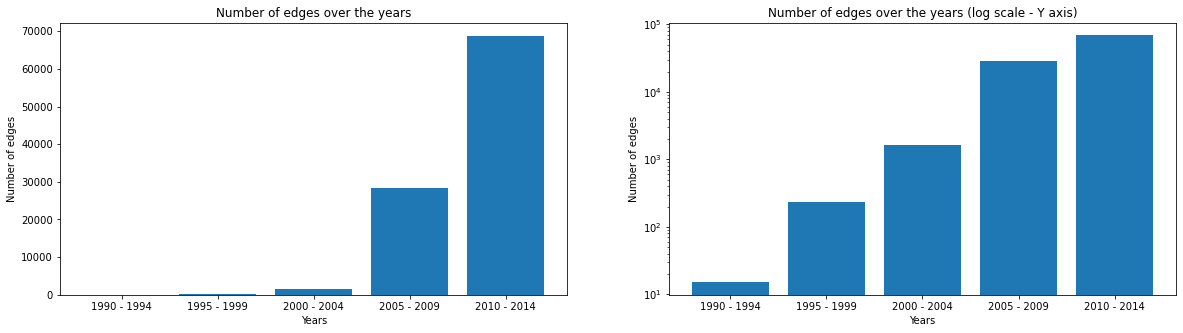

In [9]:
print('   Years     :   Edges   ')
edge_number_histogram = {f'{year_range[0]} - {year_range[1]}':graph_list[i].number_of_edges() for i, year_range  in enumerate(years_range)}
for years,edges in edge_number_histogram.items():
    print(f'{years}  :    {edges}')

fig, axs = plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axs[i].bar(edge_number_histogram.keys(), edge_number_histogram.values())
    axs[i].set_xlabel("Years")
    axs[i].set_ylabel("Number of edges")
    titel = f'Number of edges over the years'
    if i>0:
        axs[i].set_yscale('log')
        titel += ' (log scale - Y axis)'
    axs[i].set_title(titel)

   Years     :   Nodes   
1990 - 1994  :    21
1995 - 1999  :    256
2000 - 2004  :    1317
2005 - 2009  :    14250
2010 - 2014  :    35122


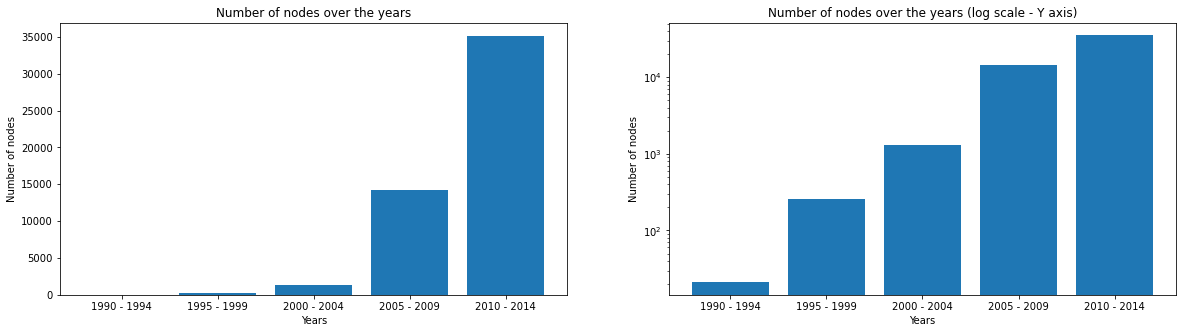

In [10]:
print('   Years     :   Nodes   ')
node_number_histogram = {f'{year_range[0]} - {year_range[1]}':graph_list[i].number_of_nodes() for i, year_range  in enumerate(years_range)}
for years,nodes in node_number_histogram.items():
    print(f'{years}  :    {nodes}')

fig, axs = plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axs[i].bar(node_number_histogram.keys(), node_number_histogram.values())
    axs[i].set_xlabel("Years")
    axs[i].set_ylabel("Number of nodes")
    titel = f'Number of nodes over the years'
    if i>0:
        axs[i].set_yscale('log')
        titel += ' (log scale - Y axis)'
    axs[i].set_title(titel)

#### Measures, Features and Plotting

Name: 
Type: MultiDiGraph
Number of nodes: 1317
Number of edges: 1635
Average in degree:   1.2415
Average out degree:   1.2415


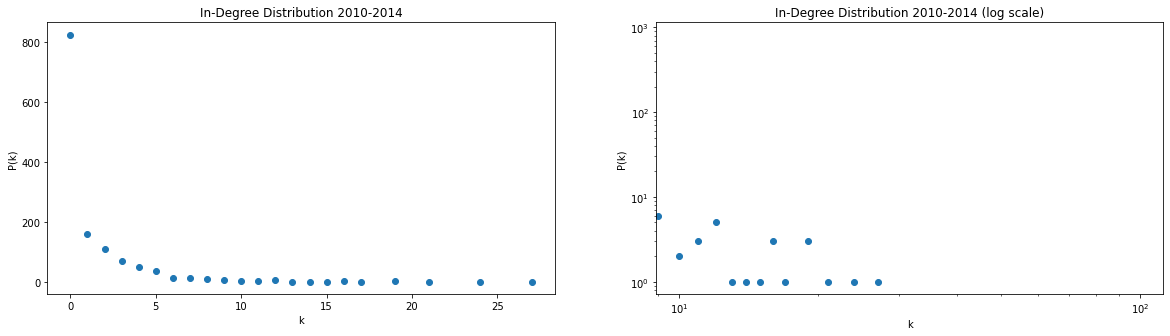

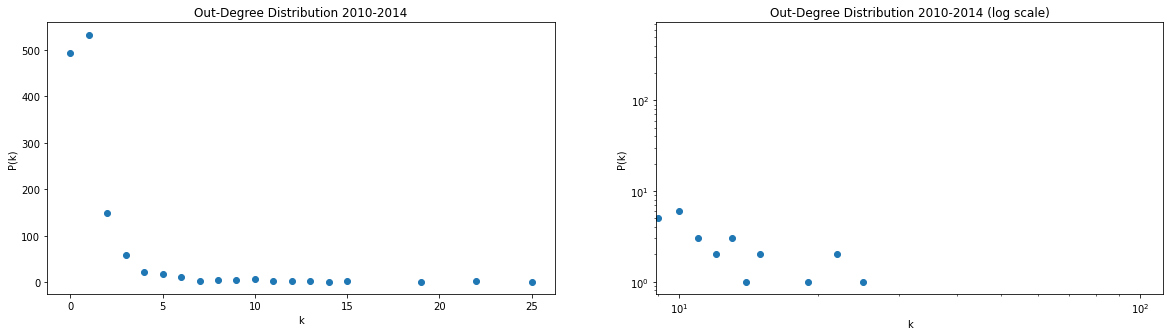

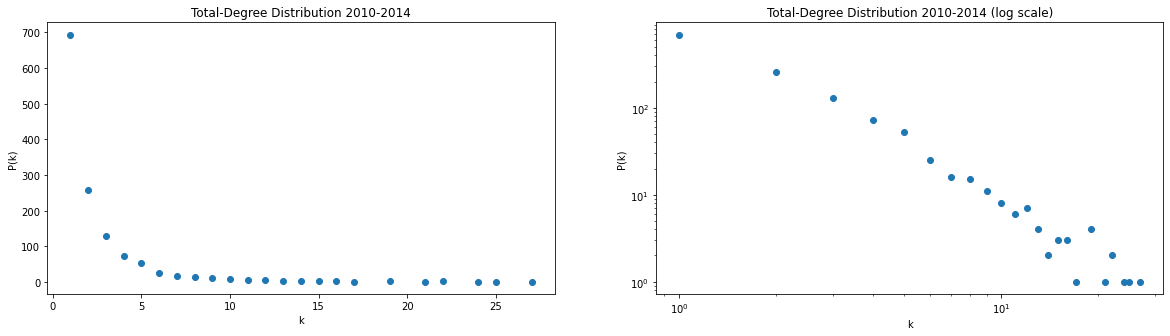

In [52]:
def plot_degree_distribution(num):
    # G_weighted_directed = nx.from_pandas_edgelist(df=df_list[4],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
    G_weighted_directed = graph_list[num]
    # nodes = pd.DataFrame(list(G_weighted_directed.nodes))
    print(nx.info(G_weighted_directed))
    # degrees = [G_weighted_directed.degree(n) for n in G_weighted_directed.nodes()]
    degree_dict = {'In':G_weighted_directed.in_degree,'Out':G_weighted_directed.out_degree,'Total':G_weighted_directed.degree}
    dic = defaultdict() # key=in/out/total : value=count_deg
    for item in degree_dict.items():
        count_deg = defaultdict(int)
        for node, degree in item[1]:
            count_deg[degree] += 1 / len(item[1])
            count_deg[degree] += 1
        dic[item[0]] = count_deg

    for j,dict in dic.items():
        fig, axs = plt.subplots(1,2,figsize=(20,5))
        for i in range(2):
            axs[i].scatter(dict.keys(), dict.values())
            # mean_k = np.mean([item[0]*item[1] for item in dict.items()])
            # max_k = max(dict.keys())
            # a = np.linspace(1, max_k, len(list(dict.keys())))
            # axs[i].plot(dict.keys(), poisson.pmf(a, mu=5))
            # axs[i].plot(np.linspace(0, max_k, 100), np.exp(np.linspace(0, max_k, 100)))
            # axs[i].plot(np.log(np.linspace(1, max_k*10, 1000000)), np.log(np.exp(np.linspace(1, max_k*10, 1000000))))
            axs[i].set_xlabel("k")
            axs[i].set_ylabel("P(k)")
            titel = f'{j}-Degree Distribution {years_range[4][0]}-{years_range[4][1]}'
            if i>0:
                axs[i].set_yscale('log')
                axs[i].set_xscale('log')
                # mean_k = np.mean([item[0]*item[1] for item in dict.items()])
                # max_k = max(dict.keys())
                # a = np.linspace(1, max_k, max_k)
                # from math import e
                # import math
                # b = [((e**(-mean_k))*(mean_k**i))/(math.factorial(i)) for i in a]
                # axs[i].plot(a,b)
                # from scipy.stats import poisson
                # axs[i].plot(np.linspace(1, max_k, 1000000), poisson.pmf((np.linspace(1, max_k, 1000000)),mu=mean_k))
                titel += ' (log scale)'
            axs[i].set_title(titel)

plot_degree_distribution(2)

In [12]:
from scipy.stats import poisson
# import matplotlib.pyplot as plt
# mu = 0.6
# fig, ax = plt.subplots(1, 1)
# x = np.arange(poisson.ppf(0.01, mu), poisson.ppf(0.99, mu))
# ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
# ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)
poisson.pmf(np.array([4,5]), mu=7)

array([0.09122619, 0.12771667])

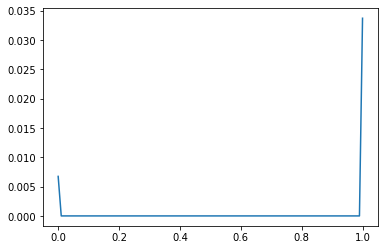

In [13]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
%matplotlib inline 

#generate Poisson distribution with sample size 10000
x = poisson.rvs(mu=3, size=1000)
a = np.linspace(0, 1, 100)
b = poisson.pmf(a, mu=5)

#create plot of Poisson distribution
plt.plot(a,b)


Calculating best minimal value for power law fit
Gamma (Total)' = 2.246406652361518


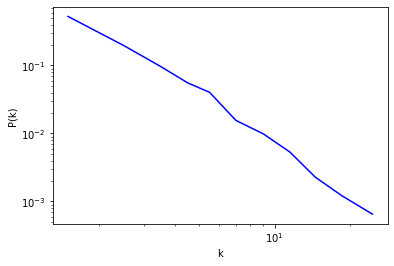

In [54]:
def plot_gamma(num):
    G_weighted_directed = graph_list[num]
    degree_dict = {'In':G_weighted_directed.in_degree,'Out':G_weighted_directed.out_degree,'Total':G_weighted_directed.degree}
    degree_sequence = sorted([d for _, d in degree_dict['Total']],reverse=True)
    figPDF = powerlaw.plot_pdf(degree_sequence,color='b')
    figPDF.set_ylabel(r"P(k)")
    figPDF.set_xlabel(r"k")
    fit = powerlaw.Fit(degree_sequence,discrete=True)
    gamma = fit.power_law.alpha
    print(f"Gamma (Total)' = {gamma}")

plot_gamma(2)

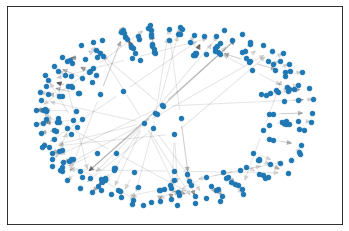

In [15]:
# Plot directional Graph

# G = nx.MultiDiGraph()
# edges = [df_list[3]]
# G = nx.from_pandas_edgelist(df=df_list[1],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
G = graph_list[1]
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 20)
nx.draw_networkx_edges(G,pos,alpha=0.1)
# nx.draw_networkx_labels(G, pos)
plt.show()

In [55]:
def print_giant_component(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.Graph())
    print('v')
    if nx.is_connected(G):
      print("Diameter(G)=",nx.diameter(G))
    else:
        print(f'Graph of years {years_dict[num][0]}-{years_dict[num][1]} is unconnected')
        print("Size giant componenet =", len(max(nx.connected_components(G),key=len)))

print_giant_component(2)

v
Graph of years 2000-2004 is unconnected
Size giant componenet = 947


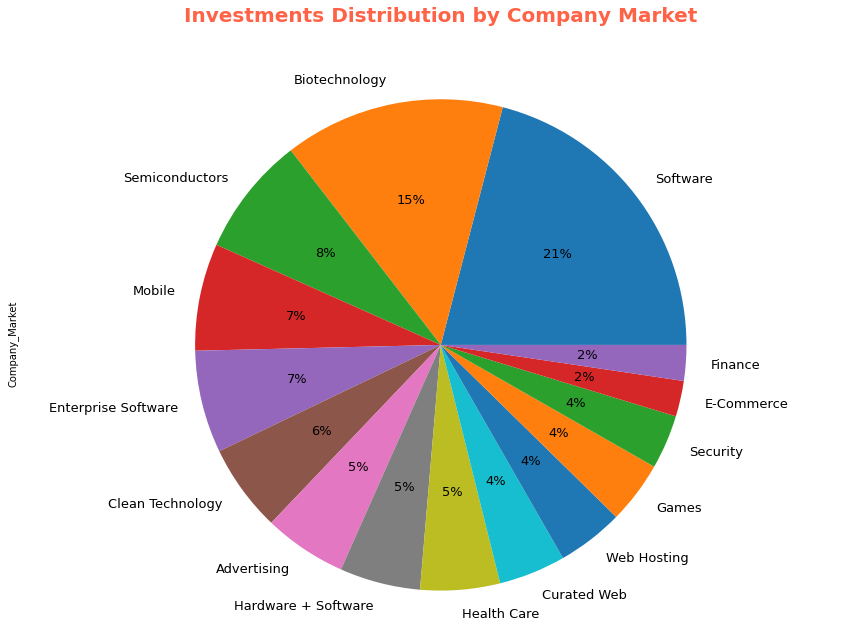

In [56]:
def plot_company_market_distribution(num): 
    df_list[num].Company_Market.value_counts().head(15).plot.pie(figsize=(15,10),autopct='%1.0f%%',fontsize=13)
    plt.title('Investments Distribution by Company Market\n\n', fontsize=20, fontweight='bold',color='tomato')
    plt.axis('equal')

plot_company_market_distribution(3)

Graphs - number of edges
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]

In [18]:
# def get_in_out_nodes(g, investors:pd.DataFrame, company_name: pd.DataFrame):
#     """
#     Split degrees to companies and investors (inbound, outbound)
#     :param g: graph
#     :param investors: investors DF
#     :param company_name: comapnies DF
#     """
#     all_degrees = g.degree
#     in_nodes = defaultdict(int)
#     out_nodes = defaultdict(int)

#     for company, n_edges in all_degrees:
#         if company in investors.values:
#             out_nodes[company] = n_edges
#         elif company in company_name.values:
#             in_nodes[company] = n_edges

#     print("Invested in companies (inbound)")
#     # print(dict(in_nodes))
#     print(in_nodes)
#     print("\n")
#     print("Investing companies (outbound)")
#     # print(dict(out_nodes))
#     print(out_nodes)
#     return in_nodes, out_nodes

# def avg_degree(nodes:dict):
#     """
#     Calculate the average degree of the nodes in the graph
#     :param nodes: dictionary of node_name(str): degree(int)
#     """
#     return sum([degree for degree in nodes.values()]) / len(nodes)

# g = graph_list[0]
# investing_companies = df_list[0]['Investor_Name']
# invested_companies = df_list[0]['Company_Name']
# inbound, outbound = get_in_out_nodes(g, investing_companies, invested_companies)
# print(avg_degree(inbound))
# print(avg_degree(outbound))


In [93]:
def build_centrality_table(num):    
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph())
    nodes = pd.DataFrame(list(G.nodes))
    #degree_centrality, in_degree_centrality, out_degree_centrality, betweenness_centrality and closeness_centrality
    measures = {'Degree': nx.degree_centrality,'In-Degree': nx.in_degree_centrality,'Out-Degree': nx.out_degree_centrality,'Betweenness': nx.betweenness_centrality,'Closeness': nx.closeness_centrality}

    for name, measure in measures.items():
        if name == 'Betweenness':
            G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
            centrality_dict = measure(G,k=min(len(G.nodes),50000))
            pass
        else:
            centrality_dict = measure(G)
        nodes[name] = nodes[0].apply(lambda x: centrality_dict.get(x, None))
    return nodes

In [94]:
centrality_table = build_centrality_table(2).rename(columns={0: "Company Name"})
centrality_table

,Company Name,Degree,In-Degree,Out-Degree,Betweenness,Closeness
0,3i Group,0.006839,0.000000,0.006839,0.0,0.000000
1,OpenAir,0.002280,0.002280,0.000000,0.0,0.002280
2,American Express,0.000760,0.000000,0.000760,0.0,0.000000
3,OpenTable,0.007599,0.007599,0.000000,0.0,0.006079
4,Argus Capital,0.001520,0.000000,0.001520,0.0,0.000000
...,...,...,...,...,...,...
1312,BiPar Sciences,0.004559,0.004559,0.000000,0.0,0.004559
1313,Quantum Technology Partners,0.000760,0.000000,0.000760,0.0,0.000000
1314,Enpirion,0.003799,0.003799,0.000000,0.0,0.003799
1315,Rostima,0.000760,0.000760,0.000000,0.0,0.000760


In [95]:
def print_centralization(num,measure):    
    table = centrality_table.sort_values([measure],ascending=False).head(10)[['Company Name',measure]]
    max_centrality = table.max()[1]
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
    table['difference'] = max_centrality-table[measure]
    centralization = table['difference'].sum()/((G.number_of_nodes()-1)*(G.number_of_nodes()-2))
    print(f'The centralization is {centralization}')

In [96]:
centrality_table.sort_values(['Degree'],ascending=False).head(10)[['Company Name','Degree']]

,Company Name,Degree
308,The FeedRoom,0.020517
113,Sequoia Capital,0.018997
511,Market Wire,0.018237
28,IDG Capital Partners,0.016717
389,Scottish Equity Partners (SEP),0.016717
481,CipherMax,0.015957
34,Intel Capital,0.014438
171,PayPal,0.014438
363,Aperto Networks,0.014438
372,ACTIVE Network,0.014438


In [97]:
print_centralization(2,'Degree')

The centralization is 2.32722481023282e-08


In [98]:
centrality_table.sort_values(['In-Degree'],ascending=False).head(10)[['Company Name','In-Degree']]

,Company Name,In-Degree
308,The FeedRoom,0.020517
511,Market Wire,0.018237
481,CipherMax,0.015957
363,Aperto Networks,0.014438
372,ACTIVE Network,0.014438
171,PayPal,0.014438
73,PowerDsine,0.012918
71,"Gomez, Inc.",0.012158
331,DivX,0.012158
527,Danger,0.012158


In [99]:
print_centralization(2,'In-Degree')

The centralization is 3.3371525580697036e-08


In [100]:
centrality_table.sort_values(['Out-Degree'],ascending=False).head(10)[['Company Name','Out-Degree']]

,Company Name,Out-Degree
113,Sequoia Capital,0.018997
28,IDG Capital Partners,0.016717
389,Scottish Equity Partners (SEP),0.016717
34,Intel Capital,0.014438
19,Draper Fisher Jurvetson (DFJ),0.011398
138,RRE Ventures,0.011398
323,New Enterprise Associates,0.010638
93,Redpoint Ventures,0.009878
51,U.S. Venture Partners,0.009878
10,Benchmark,0.009878


In [101]:
print_centralization(2,'Out-Degree')

The centralization is 3.4688822643092973e-08


In [102]:
centrality_table.sort_values(['Betweenness'],ascending=False).head(10)[['Company Name','Betweenness']]

,Company Name,Betweenness
0,3i Group,0.0
885,Carlyle Group,0.0
883,AdAstra,0.0
882,OpTier,0.0
881,eCourier.co.uk,0.0
880,Tom Allason,0.0
879,New.net,0.0
878,Finaventures,0.0
877,Metatomix,0.0
876,MTM Laboratories,0.0


In [103]:
print_centralization(2,'Betweenness')

The centralization is 0.0


In [104]:
centrality_table.sort_values(['Closeness'],ascending=False).head(10)[['Company Name','Closeness']]

,Company Name,Closeness
171,PayPal,0.014438
481,CipherMax,0.012158
308,The FeedRoom,0.011398
543,MySQL,0.010638
73,PowerDsine,0.009119
343,Sylantro,0.009119
363,Aperto Networks,0.008359
527,Danger,0.008359
372,ACTIVE Network,0.008359
76,Baidu,0.007599


In [105]:
print_centralization(2,'Closeness')

The centralization is 2.5906842227120074e-08


defaultdict(<class 'list'>, {9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

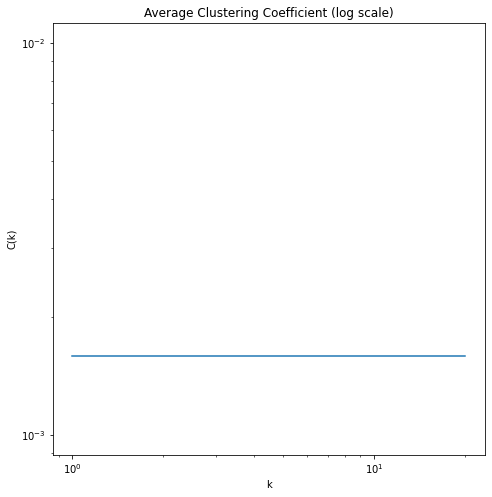

In [117]:
def plot_clustering_coefficient(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
    clustering_dict = defaultdict(list)
    for node in G.nodes():
        k = G.degree(node)
        clustering_dict[k].append(nx.clustering(G,node))
    k_list = sorted(clustering_dict.keys())
    clustering_list = []
    for k in k_list:
        clustering_list.append(np.mean(clustering_dict[k])) 
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    print(clustering_dict)
    axes.loglog(k_list,clustering_list,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average Clustering Coefficient (log scale)')
    # fig.savefig(f'plots/clustering_coefficient_{num}.png', bbox_inches='tight')
    N = G.number_of_nodes()
    L = G.number_of_edges()
    p = (2*L)/(N*(N-1))
    print('Average clustering coefficient for random graph is {}'.format(p))
    axes.plot(k_list,[p]*len(k_list))
    plt.show()
    
plot_clustering_coefficient(2)

In [33]:
def fit_func(x,a,mu):
    return (a*x)**mu

Assortative graph with mu 0.001


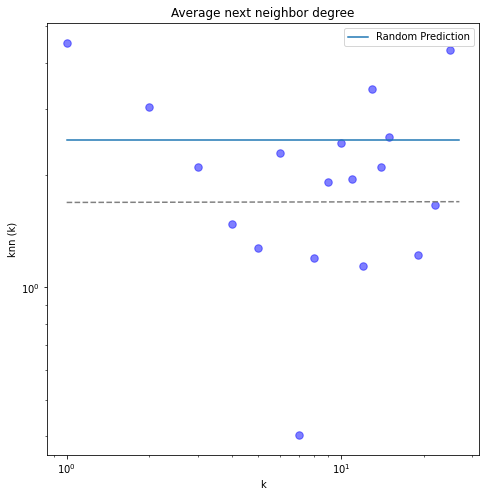

In [121]:
def plot_knn(num):
    G = graph_list[num]
    knn_dict = nx.k_nearest_neighbors(G)
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k]) 
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('knn (k)')
    axes.set_title('Average next neighbor degree')
    try:
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst),maxfev=5000)
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
        axes.plot(np.array(k_lst), np.array([2*G.number_of_edges()/G.number_of_nodes()]*len(k_lst)),label='Random Prediction')
        if popt[1] > 0:
            print(f'Assortative graph with mu {round(popt[1],3)}')
        elif popt[1] < 0:
            print(f'Disassortative graph with mu {round(popt[1],3)}')
        else:
            print(f'Neutral graph (mu = 0)')
    except:
        pass
    # fig.savefig('plots/knn.png', bbox_inches='tight')
    plt.legend()
    plt.show()
    
plot_knn(2)

<ipython-input-33-f04d1d35b1eb>:2: RuntimeWarning: invalid value encountered in power
  return (a*x)**mu
No handles with labels found to put in legend.


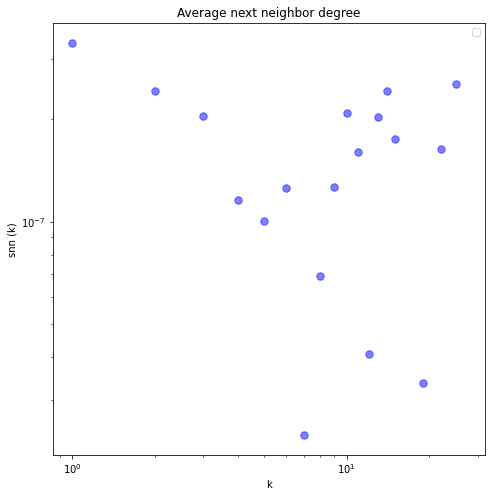

In [126]:
def plot_snn(num):
    G = graph_list[num]
    knn_dict = nx.k_nearest_neighbors(G,weight = 'Raised_Amount_USD')
    k_lst = sorted(knn_dict.keys())
    snn_lst = []
    for k in k_lst:
        snn_lst.append(knn_dict[k]) 
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('snn (k)')
    axes.set_title('Average next neighbor degree')
    try:
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst),maxfev=5000)
        print(popt)
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
        axes.plot(np.array(k_lst), np.array([2*G.number_of_edges()/G.number_of_nodes()]*len(k_lst)),label='Random Prediction')
        if popt[1] > 0:
            print(f'Assortative graph with mu {round(popt[1],3)}')
        elif popt[1] < 0:
            print(f'Disassortative graph with mu {round(popt[1],3)}')
        else:
            print(f'Neutral graph (mu = 0)')
    except:
        pass
    # fig.savefig('plots/knn.png', bbox_inches='tight')
    plt.legend()
    plt.show()
    
plot_snn(2)

In [127]:
def print_degree_correlation_coefficient(num):
    G = graph_list[num]
    calc = nx.degree_pearson_correlation_coefficient(G,x='in', y='in', weight='Raised_Amount_USD', nodes=None)
    if calc > 0:
        print(f'Assortative graph with r = {round(calc,3)}')
    elif calc < 0:
        print(f'Disassortative graph with r = {round(calc,3)}')
    else:
        print(f'Neutral graph (r = 0)')

print_degree_correlation_coefficient(2)

Neutral graph (r = 0)


c:\Users\omery\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 The average weight is 14363944.945 USD


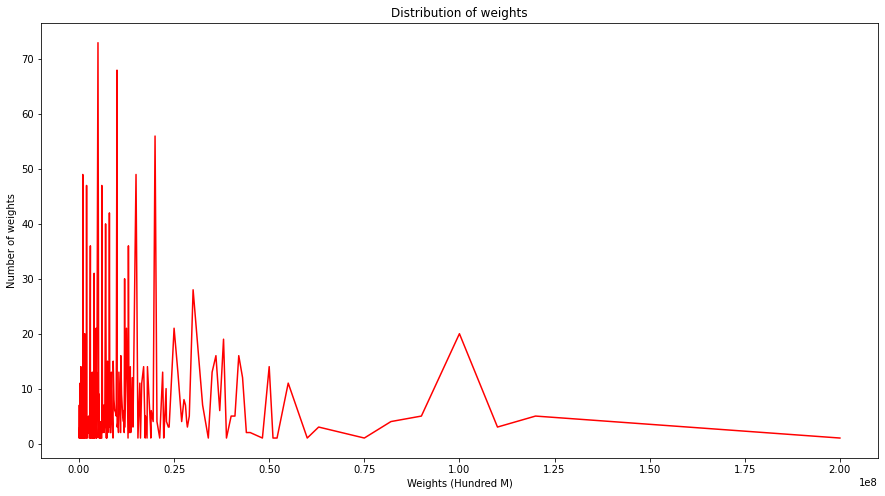

In [162]:
def plot_weight_dist(num):
    G = graph_list[num]
    weight_list = sorted(list((nx.get_edge_attributes(G,'Raised_Amount_USD').values())))
    weight_dict = defaultdict(int)
    for w in weight_list:
        weight_dict[w] += 1
    weights = []
    counts = []
    for weight,cnt in weight_dict.items():
        weights.append(weight)
        counts.append(cnt)
    plt.figure(figsize=(15,8))
    plt.xlabel("Weights (Hundred M)")
    plt.ylabel("Number of weights")
    plt.title(f'Distribution of weights')
    plt.plot(weights,counts,c='r')
    
    avg_w=0
    for i in range(len(weights)):
        avg_w+=weights[i]*counts[i]/sum(counts)
    print(f' The average weight is {round(avg_w,3)} USD')
    
plot_weight_dist(2)
    

Average weight is 7.598
Maximum distance is 19


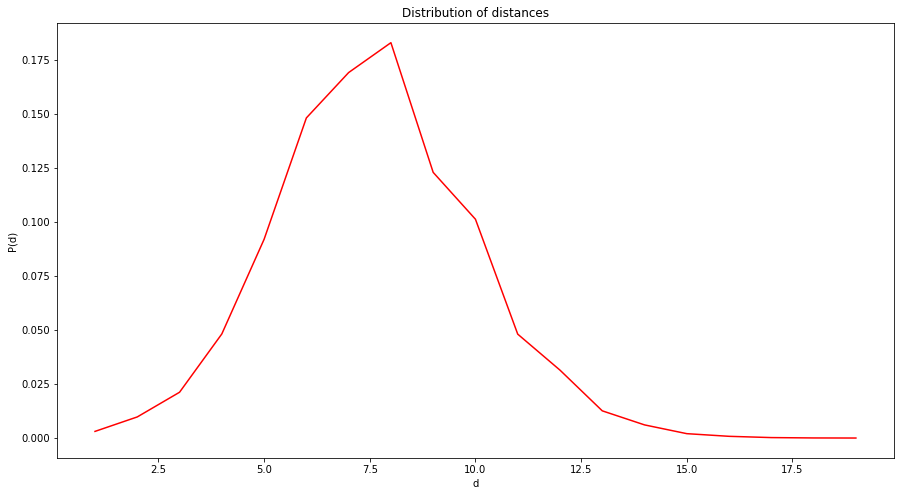

In [160]:
def plot_distance_dist(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.Graph())
    shortest_path = nx.shortest_path_length(G)
    distance_dict = defaultdict(int)

    for i in shortest_path:
        for j in i[1].values():
            if j > 0:
                distance_dict[j] += 1
    distances = []
    counts = []
    for item in distance_dict.items():
        distances.append(item[0])
        counts.append(item[1]/np.sum(list(distance_dict.values())))

    plt.figure(figsize=(15,8))
    plt.xlabel("d")
    plt.ylabel("P(d)")
    plt.title(f'Distribution of distances')
    plt.plot(distances,counts,c='r')

    avg_d=0
    for i in range(len(distances)):
        avg_d+=distances[i]*counts[i]/sum(counts)
    print(f'Average weight is {round(avg_d,3)}')
    print(f'Maximum distance is {max(distances)}')
    
plot_distance_dist(2)

In [49]:
def Communitys(num):
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.Graph())
    
    #Using the Kernighan–Lin algorithm
    KL_communities_generator = community.kernighan_lin_bisection(G,max_iter=10)
    #Measuring partitions by modularity
    print (community.modularity(G, KL_communities_generator))

    #Communities with modularity
    greedy_mod=greedy_modularity_communities(G)
    print (community.modularity(G, greedy_mod))
    
    #Giravn _newman communities:
    GN_communities_generator = c.girvan_newman(G)
    for i in range(10):
        communities= next(GN_communities_generator)

    GN_comm_sets = sorted(map(sorted, communities))
    #Measuring partitions by modularity
    print (community.modularity(G, GN_comm_sets))
    
    #Louvain communities:
    partition = community_louvain.best_partition(G)
    
    d_for_getting_num_of_com={}
    for x in partition:
        if partition[x] not in d_for_getting_num_of_com:
            d_for_getting_num_of_com[partition[x]]=1
    empty_lists = [ [] for l in range(len(d_for_getting_num_of_com) ) ]
    
    for node in partition:
        empty_lists[partition[node]].append(node)
    print (community.modularity(G,empty_lists))

    return KL_communities_generator, greedy_mod, GN_comm_sets, partition

print(Communitys(2))

In [39]:
##############################################################
####################### Do Not Delete ########################
##############################################################

# # Make the gephi's files
# graph_list_for_attr = []
# for i,df in enumerate(df_list):
#     attr_dic = {x:y for x, y in zip(df['Company_Name'], df['Company_Market'])}
#     attr_dic_fixed = {x:'Investors' for x in df['Investor_Name']}
#     attr_dic_fixed.update(attr_dic)
#     graph = nx.from_pandas_edgelist(df,source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph())
#     nx.set_node_attributes(graph, attr_dic_fixed, name="Sector")
#     graph_list_for_attr.append(graph)
#     nx.write_gexf(graph, f"Gephi{i}.gexf")